In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import os
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
path = os.path.join('..', 'Dataset\\CIFAR10')
os.listdir(path)

['batches.meta',
 'data_batch_1',
 'data_batch_2',
 'data_batch_3',
 'data_batch_4',
 'data_batch_5',
 'readme.html',
 'test_batch']

In [3]:
def unpickle(path):
    with open(path, 'rb') as f:
        data = pickle._Unpickler(f)
        data.encoding = 'latin1'
        d = data.load()
    return d

In [4]:
def one_hot_encode(data, categories):
    
    val = np.eye(categories)
    return val[data]

In [5]:
def data_load():
    data = [unpickle(path + '\\data_batch_{}'.format(i)) for i in range(1, 6)]
    images = np.vstack([i['data'] for i in data])
    label = np.hstack([i['labels'] for i in data])
    images = images.reshape(images.shape[0], 3, 32, 32).transpose(0, 2, 3, 1)
    
    return images, one_hot_encode(label, 10)

In [6]:
images, label = data_load()

In [7]:
images.shape

(50000, 32, 32, 3)

In [8]:
def display_cifar(images, size):
     n = len(images)
     plt.figure()
     plt.gca().set_axis_off()
     im = np.vstack([np.hstack([images[np.random.choice(n)] for i in range(size)])
     for i in range(size)])
     plt.imshow(im)
     plt.show()

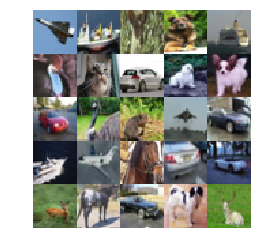

In [9]:
display_cifar(images, 5)

In [10]:
img = images / 255

In [11]:
def W_initial(shape, mu = 0, std = 1):
    return tf.Variable(tf.random.normal(shape, mu, std, name = 'W_initial'), name = 'Weight')

def b_initial(shape, mu = 0, std = 1):
    return tf.Variable(tf.random.normal(shape, mu, std, name = 'b_initial'), name = 'Bias')

def conv2D(x, shape):
    kernel = W_initial(shape, std = 0.1) ## Have to assign later
    bias = b_initial([shape[3]], std = 0.1) ## Have to assign later
    conv = tf.nn.conv2d(x, kernel, padding = 'SAME', strides=[1,1,1,1])
    print (conv)
    return tf.nn.relu(conv + bias)

def max_pool_2x2(x):    
    pool = tf.nn.max_pool(x, ksize = [1, 2, 2, 1], strides=[1, 2, 2, 1], padding = 'SAME')
    print (pool)
    return pool
def fully_connected_layer(x, shape):
    
    W = W_initial(shape) ## Have to assign later
    b = b_initial([shape[3]])
    result = tf.matmul(x, W) + b
    return tf.nn.relu(result)

In [12]:
x = tf.placeholder(tf.float32, shape = (None, 32, 32, 3), name = 'Input_Data')
y_true = tf.placeholder(tf.float32, shape = (None, 10), name = 'true_result')

In [13]:
C1, C2, C3 = 32, 64, 128
conv1 = conv2D(x, [5, 5, 3, C1])
conv2 = conv2D(conv1, [3, 3, C1, C2])
conv3 = conv2D(conv2, [7, 7, C2, C2])
max_pool = max_pool_2x2(conv3)

conv1 = conv2D(max_pool, [3, 3, C2, C3])
conv2 = conv2D(conv1, [3, 3, C3, C2])
conv3 = conv2D(conv2, [7, 7, C2, C2])
dense = fully_connected_layer(conv3, [16, 16, C2, C1])
flatten = tf.reshape(max_pool, (-1, 16 * 16 * 64))
print(flatten.shape)
W_final = W_initial([16384, 10])
b_final = b_initial([10])
result = tf.nn.softmax(tf.matmul(flatten, W_final) + b_final)
result.shape

Instructions for updating:
Colocations handled automatically by placer.
Tensor("Conv2D:0", shape=(?, 32, 32, 32), dtype=float32)
Tensor("Conv2D_1:0", shape=(?, 32, 32, 64), dtype=float32)
Tensor("Conv2D_2:0", shape=(?, 32, 32, 64), dtype=float32)
Tensor("MaxPool:0", shape=(?, 16, 16, 64), dtype=float32)
Tensor("Conv2D_3:0", shape=(?, 16, 16, 128), dtype=float32)
Tensor("Conv2D_4:0", shape=(?, 16, 16, 64), dtype=float32)
Tensor("Conv2D_5:0", shape=(?, 16, 16, 64), dtype=float32)
(?, 16384)


TensorShape([Dimension(None), Dimension(10)])

In [14]:
with tf.name_scope('Loss') as sess:
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y_true, logits = result))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [15]:
with tf.name_scope('Accuracy') as sess:
    
    mask = tf.equal(tf.argmax(result, axis = 1), tf.argmax(y_true, axis = 1))
    accuracy = tf.reduce_mean(tf.cast(mask, tf.float32))


In [16]:
gd_step= tf.train.AdamOptimizer(1).minimize(loss)

In [17]:
NUM_STEPS = 1000
loss_dir = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    index = np.arange(0, images.shape[0])
    np.random.shuffle(index)
    images1 = img[index]
    y_lab = label[index]
    x_train, x_test, y_train, y_test = train_test_split(images1, y_lab, test_size = 0.3)
    batch_index = np.arange(0, x_train.shape[0])
    
    for i in range(NUM_STEPS):
        ind = np.random.choice(batch_index, 512)
        l, a, g = sess.run([loss, accuracy, gd_step], feed_dict = {x:x_train[ind], y_true: y_train[ind]})
        loss_dir.append(l)
        print ('Iteration: ', i, ' Loss: ', l, ' Accuracy: ', a)
    
    acc = sess.run([accuracy], feed_dict = {x: x_test[:1000], y_true: y_test[:1000]})

Iteration:  0  Loss:  2.3693423  Accuracy:  0.091796875
Iteration:  1  Loss:  2.3693533  Accuracy:  0.091796875
Iteration:  2  Loss:  2.3732595  Accuracy:  0.087890625
Iteration:  3  Loss:  2.3576345  Accuracy:  0.103515625
Iteration:  4  Loss:  2.3556814  Accuracy:  0.10546875
Iteration:  5  Loss:  2.3674002  Accuracy:  0.09375
Iteration:  6  Loss:  2.3674002  Accuracy:  0.09375
Iteration:  7  Loss:  2.3771658  Accuracy:  0.083984375
Iteration:  8  Loss:  2.3674002  Accuracy:  0.09375
Iteration:  9  Loss:  2.3576345  Accuracy:  0.103515625
Iteration:  10  Loss:  2.3595877  Accuracy:  0.1015625
Iteration:  11  Loss:  2.3537283  Accuracy:  0.107421875
Iteration:  12  Loss:  2.3537283  Accuracy:  0.107421875
Iteration:  13  Loss:  2.363494  Accuracy:  0.09765625
Iteration:  14  Loss:  2.379119  Accuracy:  0.08203125
Iteration:  15  Loss:  2.3537283  Accuracy:  0.107421875
Iteration:  16  Loss:  2.3615408  Accuracy:  0.099609375
Iteration:  17  Loss:  2.3420095  Accuracy:  0.119140625
Ite

Iteration:  147  Loss:  2.3732595  Accuracy:  0.087890625
Iteration:  148  Loss:  2.3556814  Accuracy:  0.10546875
Iteration:  149  Loss:  2.3595877  Accuracy:  0.1015625
Iteration:  150  Loss:  2.3713064  Accuracy:  0.08984375
Iteration:  151  Loss:  2.363494  Accuracy:  0.09765625
Iteration:  152  Loss:  2.3556814  Accuracy:  0.10546875
Iteration:  153  Loss:  2.3283377  Accuracy:  0.1328125
Iteration:  154  Loss:  2.3674002  Accuracy:  0.09375
Iteration:  155  Loss:  2.3752127  Accuracy:  0.0859375
Iteration:  156  Loss:  2.363494  Accuracy:  0.09765625
Iteration:  157  Loss:  2.363494  Accuracy:  0.09765625
Iteration:  158  Loss:  2.3693533  Accuracy:  0.091796875
Iteration:  159  Loss:  2.3849783  Accuracy:  0.076171875
Iteration:  160  Loss:  2.363494  Accuracy:  0.09765625
Iteration:  161  Loss:  2.3674002  Accuracy:  0.09375
Iteration:  162  Loss:  2.3732595  Accuracy:  0.087890625
Iteration:  163  Loss:  2.318572  Accuracy:  0.14257812
Iteration:  164  Loss:  2.3908377  Accura

Iteration:  292  Loss:  2.3693533  Accuracy:  0.091796875
Iteration:  293  Loss:  2.363494  Accuracy:  0.09765625
Iteration:  294  Loss:  2.3615408  Accuracy:  0.099609375
Iteration:  295  Loss:  2.349822  Accuracy:  0.111328125
Iteration:  296  Loss:  2.3752127  Accuracy:  0.0859375
Iteration:  297  Loss:  2.3576345  Accuracy:  0.103515625
Iteration:  298  Loss:  2.379119  Accuracy:  0.08203125
Iteration:  299  Loss:  2.363494  Accuracy:  0.09765625
Iteration:  300  Loss:  2.3849783  Accuracy:  0.076171875
Iteration:  301  Loss:  2.3595877  Accuracy:  0.1015625
Iteration:  302  Loss:  2.3400564  Accuracy:  0.12109375
Iteration:  303  Loss:  2.334197  Accuracy:  0.12695312
Iteration:  304  Loss:  2.3771658  Accuracy:  0.083984375
Iteration:  305  Loss:  2.3556814  Accuracy:  0.10546875
Iteration:  306  Loss:  2.3517752  Accuracy:  0.109375
Iteration:  307  Loss:  2.3752127  Accuracy:  0.0859375
Iteration:  308  Loss:  2.363494  Accuracy:  0.09765625
Iteration:  309  Loss:  2.3693533  A

Iteration:  437  Loss:  2.3830252  Accuracy:  0.078125
Iteration:  438  Loss:  2.379119  Accuracy:  0.08203125
Iteration:  439  Loss:  2.3439627  Accuracy:  0.1171875
Iteration:  440  Loss:  2.3537283  Accuracy:  0.107421875
Iteration:  441  Loss:  2.3381033  Accuracy:  0.123046875
Iteration:  442  Loss:  2.3615408  Accuracy:  0.099609375
Iteration:  443  Loss:  2.365447  Accuracy:  0.095703125
Iteration:  444  Loss:  2.3595877  Accuracy:  0.1015625
Iteration:  445  Loss:  2.3752127  Accuracy:  0.0859375
Iteration:  446  Loss:  2.363494  Accuracy:  0.09765625
Iteration:  447  Loss:  2.3752127  Accuracy:  0.0859375
Iteration:  448  Loss:  2.3420095  Accuracy:  0.119140625
Iteration:  449  Loss:  2.3732595  Accuracy:  0.087890625
Iteration:  450  Loss:  2.3713064  Accuracy:  0.08984375
Iteration:  451  Loss:  2.3732595  Accuracy:  0.087890625
Iteration:  452  Loss:  2.3713064  Accuracy:  0.08984375
Iteration:  453  Loss:  2.3615408  Accuracy:  0.099609375
Iteration:  454  Loss:  2.314665

Iteration:  582  Loss:  2.347869  Accuracy:  0.11328125
Iteration:  583  Loss:  2.3595877  Accuracy:  0.1015625
Iteration:  584  Loss:  2.363494  Accuracy:  0.09765625
Iteration:  585  Loss:  2.363494  Accuracy:  0.09765625
Iteration:  586  Loss:  2.349822  Accuracy:  0.111328125
Iteration:  587  Loss:  2.3615408  Accuracy:  0.099609375
Iteration:  588  Loss:  2.3693533  Accuracy:  0.091796875
Iteration:  589  Loss:  2.3576345  Accuracy:  0.103515625
Iteration:  590  Loss:  2.3517752  Accuracy:  0.109375
Iteration:  591  Loss:  2.3771658  Accuracy:  0.083984375
Iteration:  592  Loss:  2.3517752  Accuracy:  0.109375
Iteration:  593  Loss:  2.347869  Accuracy:  0.11328125
Iteration:  594  Loss:  2.363494  Accuracy:  0.09765625
Iteration:  595  Loss:  2.363494  Accuracy:  0.09765625
Iteration:  596  Loss:  2.3732595  Accuracy:  0.087890625
Iteration:  597  Loss:  2.3595877  Accuracy:  0.1015625
Iteration:  598  Loss:  2.3713064  Accuracy:  0.08984375
Iteration:  599  Loss:  2.3517752  Acc

Iteration:  727  Loss:  2.3713064  Accuracy:  0.08984375
Iteration:  728  Loss:  2.3439627  Accuracy:  0.1171875
Iteration:  729  Loss:  2.3693533  Accuracy:  0.091796875
Iteration:  730  Loss:  2.349822  Accuracy:  0.111328125
Iteration:  731  Loss:  2.3537283  Accuracy:  0.107421875
Iteration:  732  Loss:  2.3576345  Accuracy:  0.103515625
Iteration:  733  Loss:  2.3615408  Accuracy:  0.099609375
Iteration:  734  Loss:  2.3771658  Accuracy:  0.083984375
Iteration:  735  Loss:  2.349822  Accuracy:  0.111328125
Iteration:  736  Loss:  2.3771658  Accuracy:  0.083984375
Iteration:  737  Loss:  2.3537283  Accuracy:  0.107421875
Iteration:  738  Loss:  2.3732595  Accuracy:  0.087890625
Iteration:  739  Loss:  2.3517752  Accuracy:  0.109375
Iteration:  740  Loss:  2.3420095  Accuracy:  0.119140625
Iteration:  741  Loss:  2.363494  Accuracy:  0.09765625
Iteration:  742  Loss:  2.365447  Accuracy:  0.095703125
Iteration:  743  Loss:  2.349822  Accuracy:  0.111328125
Iteration:  744  Loss:  2.

Iteration:  872  Loss:  2.3693533  Accuracy:  0.091796875
Iteration:  873  Loss:  2.3517752  Accuracy:  0.109375
Iteration:  874  Loss:  2.3439627  Accuracy:  0.1171875
Iteration:  875  Loss:  2.3537283  Accuracy:  0.107421875
Iteration:  876  Loss:  2.363494  Accuracy:  0.09765625
Iteration:  877  Loss:  2.379119  Accuracy:  0.08203125
Iteration:  878  Loss:  2.363494  Accuracy:  0.09765625
Iteration:  879  Loss:  2.3752127  Accuracy:  0.0859375
Iteration:  880  Loss:  2.3439627  Accuracy:  0.1171875
Iteration:  881  Loss:  2.3556814  Accuracy:  0.10546875
Iteration:  882  Loss:  2.363494  Accuracy:  0.09765625
Iteration:  883  Loss:  2.3576345  Accuracy:  0.103515625
Iteration:  884  Loss:  2.3459158  Accuracy:  0.115234375
Iteration:  885  Loss:  2.3576345  Accuracy:  0.103515625
Iteration:  886  Loss:  2.332244  Accuracy:  0.12890625
Iteration:  887  Loss:  2.347869  Accuracy:  0.11328125
Iteration:  888  Loss:  2.3732595  Accuracy:  0.087890625
Iteration:  889  Loss:  2.3771658  A

In [18]:
acc

[0.102]